In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import cv2
import matplotlib.pyplot as plt
import os
from os import listdir
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from PIL import Image
import imutils
from tqdm import tqdm

In [ ]:
def crop_img(img):
    # Find the extreme points and take a reactangle out of them
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # colored to grayscale image
    gray = cv2.GaussianBlur(gray, (3, 3), 0) # to reduce noise in the image

    # find contours in thresholded image, then grab the largest one
    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres = cv2.erode(thres, None, iterations=2)
    thres = cv2.dilate(thres, None, iterations=2)
    # we usually want the focused part to be white for it to be detected correctly
    # Image contouring is process of identifying structural outlines of objects for better detection
    cntrs = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # image, contour retrieval method and contour approximation
    cntrs = imutils.grab_contours(cntrs) # actually obtain the contours
    c = max(cntrs, key=cv2.contourArea) # obtain the largest contour
    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise

    # Now that we have obtained the largest contour of an image, we must determine the extreme points
    # find the extreme points

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # adding the contour on image
    img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

    # adding the extreme points
    img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
    img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
    img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
    img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

    # crop
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img

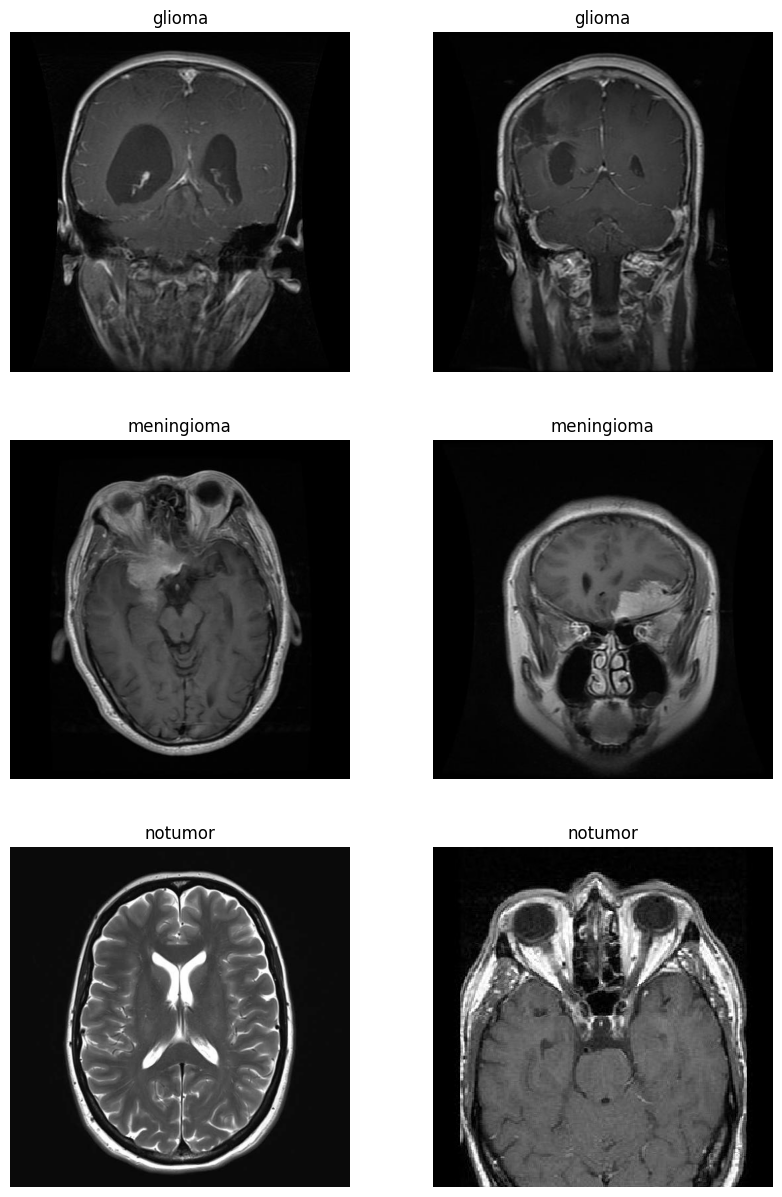

In [ ]:
dirs=('/content/drive/MyDrive/Training')
categories=['glioma','glioma', 'meningioma', 'meningioma','notumor','notumor']
plt.figure(figsize=(10,15))
img_path=['/glioma/Tr-gl_0015.jpg', '/glioma/Tr-gl_0010.jpg', '/meningioma/Tr-meTr_0005.jpg', '/meningioma/Tr-meTr_0000.jpg', '/notumor/Tr-noTr_0005.jpg', '/notumor/Tr-noTr_0000.jpg']

for i in range(0, 6):
    ax=plt.subplot(3, 2, i + 1)
    img=cv2.imread(dirs + img_path[i])
    new_img=crop_img(img)
    plt.imshow(img)
    plt.axis('off')
    plt.title(categories[i])

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Training/meningioma/Tr-meTr_0000.jpg')
img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

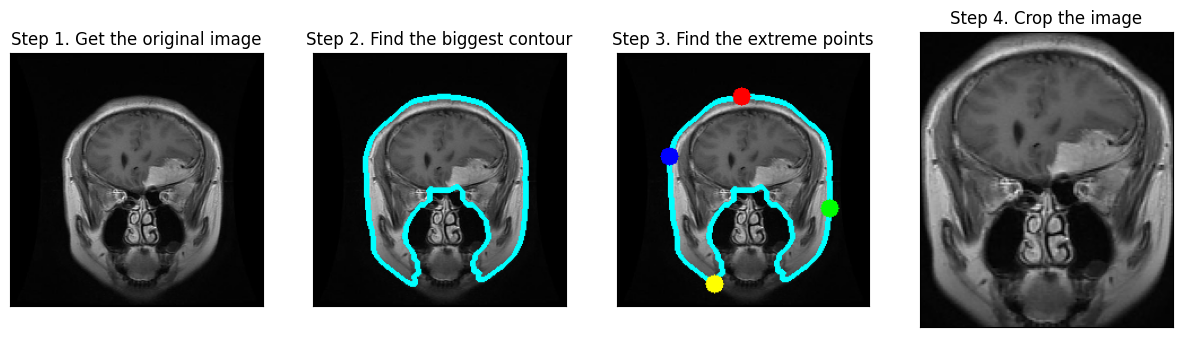

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [ ]:
# RUN THIS SECTION OF CODE ONLY ONCE,BECAUSE HERE A NEW DATASET IS CREATED IN YOUR GOOGLE DRIVER SO ONCE YOU RUN THIS,IT IS CREATED  >>>>>>>>>>>>
training='/content/drive/MyDrive/Training/'

training_dir=os.listdir(training)

img_size=200

for dir in training_dir:
    save_path=training + '/cropped/' + dir
    path=os.path.join(training, dir)
    image_dir=os.listdir(path)
    for img in image_dir:
        image=cv2.imread(os.path.join(path, img))
        new_img=crop_img(image)
        new_img=cv2.resize(new_img, (img_size, img_size))
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        cv2.imwrite(save_path+'/'+img, new_img)


In [ ]:
labels = ['glioma', 'meningioma', 'notumor']

x = [] # training images.
y  = [] # training labels.

image_size = 150


for label in labels:
    trainPath = os.path.join('/content/drive/MyDrive/Training/cropped', label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x.append(image)
        y.append(labels.index(label))

100%|██████████| 1595/1595 [00:26<00:00, 60.57it/s] 


In [ ]:
print(y)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, shuffle = True)

l = len(x_test)//2
x_valid, y_valid = x_test[:l], y_test[:l]
x_test, y_test = x_test[l:], y_test[l:]

In [ ]:
x_train=np.array(x_train)
x_train = (x_train.astype('float32') )/ 255
x_test=np.array(x_test)
x_test = (x_test.astype('float32') )/ 255
x_valid=np.array(x_valid)
x_valid = (x_valid.astype('float32') )/ 255

y_train = np.array(y_train)
y_test = np.array(y_test)
y_valid = np.array(y_valid)
print(x_train.shape)
print(x_test.shape)
print(x_valid.shape)

(3404, 150, 150, 3)
(426, 150, 150, 3)
(425, 150, 150, 3)


In [ ]:
print(x_train.shape)
print(x_train[1][1])
print(type(x_train[1]))
print(y_train.shape)

(3404, 150, 150, 3)
[[0.05490196 0.03921569 0.03921569]
 [0.05490196 0.03921569 0.03921569]
 [0.05490196 0.03921569 0.03921569]
 [0.05490196 0.03921569 0.03921569]
 [0.05490196 0.03921569 0.03921569]
 [0.05490196 0.03921569 0.03921569]
 [0.05490196 0.03921569 0.03921569]
 [0.05490196 0.03921569 0.03921569]
 [0.05490196 0.03921569 0.03921569]
 [0.05490196 0.03921569 0.03921569]
 [0.05490196 0.03921569 0.03921569]
 [0.05490196 0.03921569 0.03921569]
 [0.05490196 0.03921569 0.03921569]
 [0.05490196 0.03921569 0.03921569]
 [0.05490196 0.03921569 0.03921569]
 [0.05490196 0.03921569 0.03921569]
 [0.05490196 0.03921569 0.03921569]
 [0.05490196 0.03921569 0.03921569]
 [0.05490196 0.03921569 0.03921569]
 [0.05490196 0.03921569 0.03921569]
 [0.05490196 0.03921569 0.03921569]
 [0.05490196 0.03921569 0.03921569]
 [0.05098039 0.03921569 0.03921569]
 [0.05098039 0.03921569 0.03921569]
 [0.05098039 0.03921569 0.03921569]
 [0.05490196 0.03921569 0.03921569]
 [0.0627451  0.04313726 0.04313726]
 [0.0666

In [ ]:
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=9, padding='same', activation='relu', input_shape=(150,150,3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.45))

model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=9,padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters=36, kernel_size=9, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.15))


model.add(tf.keras.layers.Dense(3, activation='sigmoid'))

# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      3904      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 75, 75, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 16)        20752     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 16)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 37, 37, 16)       

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['acc'])

In [ ]:
Custom_CNN = model.fit(x_train,
         y_train,
         batch_size=32,
         epochs=100,
         validation_data=(x_valid, y_valid),)

Epoch 1/100
107/107 [==============================] - 4s 36ms/step - loss: 0.0094 - acc: 0.9971 - val_loss: 0.5181 - val_acc: 0.9106
Epoch 2/100
107/107 [==============================] - 4s 33ms/step - loss: 0.0162 - acc: 0.9959 - val_loss: 0.6215 - val_acc: 0.8753
Epoch 3/100
107/107 [==============================] - 4s 35ms/step - loss: 0.0239 - acc: 0.9938 - val_loss: 0.6849 - val_acc: 0.8729
Epoch 4/100
107/107 [==============================] - 3s 32ms/step - loss: 0.0167 - acc: 0.9947 - val_loss: 0.6089 - val_acc: 0.8894
Epoch 5/100
107/107 [==============================] - 4s 33ms/step - loss: 0.0117 - acc: 0.9953 - val_loss: 0.4976 - val_acc: 0.9176
Epoch 6/100
107/107 [==============================] - 4s 34ms/step - loss: 0.0049 - acc: 0.9979 - val_loss: 0.5182 - val_acc: 0.9247
Epoch 7/100
107/107 [==============================] - 4s 33ms/step - loss: 0.0134 - acc: 0.9965 - val_loss: 1.1972 - val_acc: 0.8141
Epoch 8/100
107/107 [==============================] - 3s 32ms

In [ ]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])
# 0: test loss, 1: test accuracy

#model.save('/content/drive/MyDrive/Training/tumours_Base')


 Test accuracy: 0.8708920478820801


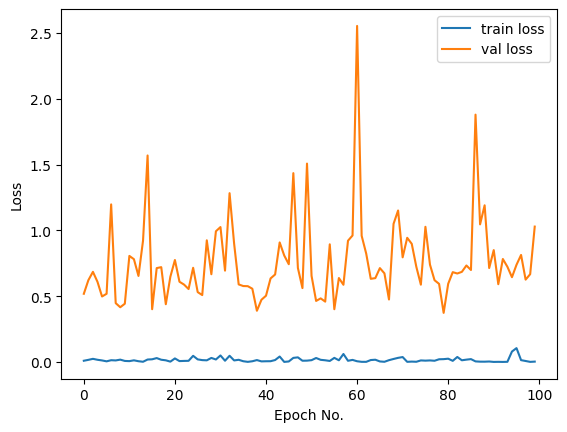

In [ ]:
plt.plot(Custom_CNN.history['loss'], label='train loss')
plt.plot(Custom_CNN.history['val_loss'], label='val loss')
plt.xlabel('Epoch No.')
plt.ylabel('Loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

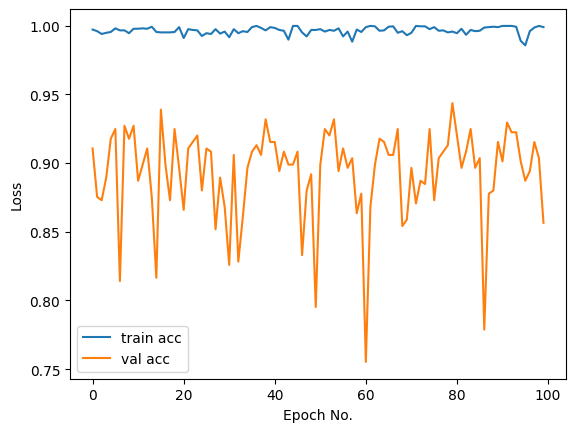

In [ ]:
plt.plot(Custom_CNN.history['acc'], label='train acc')
plt.plot(Custom_CNN.history['val_acc'], label='val acc')
plt.xlabel('Epoch No.')
plt.ylabel('Loss')
plt.legend()
plt.savefig('vgg-acc-rps-1.png')
plt.show()

14/14 [==============================] - 0s 14ms/step
                       precision    recall  f1-score   support

    giloma (Class 0 )       0.97      0.76      0.85       181
muningioma (Classs 1)       0.73      0.94      0.82       110
   no tumor (class 1)       0.92      0.96      0.94       135

             accuracy                           0.87       426
            macro avg       0.87      0.89      0.87       426
         weighted avg       0.89      0.87      0.87       426



Text(50.722222222222214, 0.5, 'Actual values')

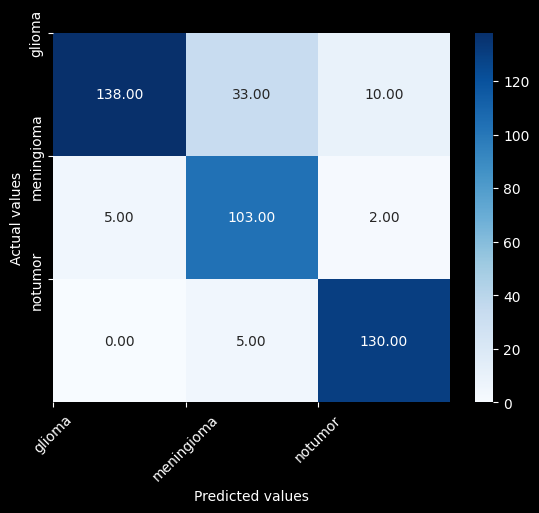

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sns
#predict
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)

#get classification repor
print(classification_report(y_pred,y_test,target_names=['giloma (Class 0 )','muningioma (Classs 1)','no tumor (class 1)']))
with plt.style.context('dark_background'):
    cm=confusion_matrix(y_pred,y_test)
    sns.heatmap(cm,annot=True,cmap=plt.cm.Blues,fmt='.2f',)
    tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels,)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')




14/14 [==============================] - 0s 14ms/step
                       precision    recall  f1-score   support

    giloma (Class 0 )       0.97      0.76      0.85       181
muningioma (Classs 1)       0.73      0.94      0.82       110
   no tumor (class 1)       0.92      0.96      0.94       135

             accuracy                           0.87       426
            macro avg       0.87      0.89      0.87       426
         weighted avg       0.89      0.87      0.87       426



Text(50.722222222222214, 0.5, 'Actual values')

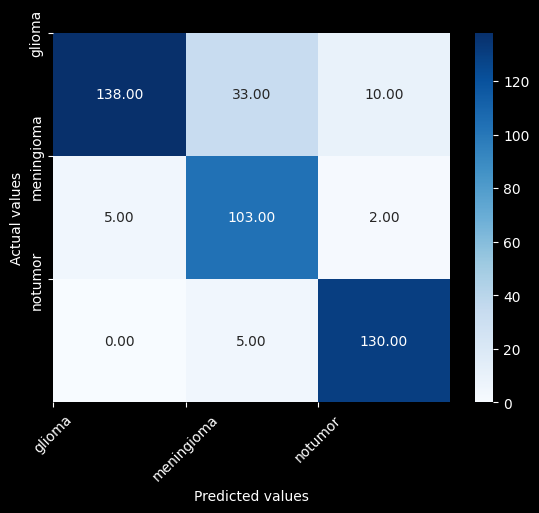

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sns
#predict
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)

#get classification repor
print(classification_report(y_pred,y_test,target_names=['giloma (Class 0 )','muningioma (Classs 1)','no tumor (class 1)']))
with plt.style.context('dark_background'):
    cm=confusion_matrix(y_pred,y_test)
    sns.heatmap(cm,annot=True,cmap=plt.cm.Blues,fmt='.2f',)
    tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')



In [ ]:
cm = confusion_matrix(y_pred,y_test)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = np.sum(cm) - (FP + FN + TP)
print(FP,FN,TP,TN)

[ 5 38 12] [43  7  5] [138 103 130] [240 278 279]


In [ ]:
P = TP/(TP+FP)
print(TP/(TP+FP))

[0.96503497 0.73049645 0.91549296]


In [ ]:
print(TP/(TP+FN))

[0.76243094 0.93636364 0.96296296]


In [ ]:
A = (TP+TN)/(TP+FP+FN+TN)
print(A)

[0.88732394 0.8943662  0.9600939 ]


In [ ]:
print(cm)

[[138  33  10]
 [  5 103   2]
 [  0   5 130]]


In [ ]:
Pyes = ((TP+TN)/(TP+FN+FP+TN))*((TP+FN)/(TP+FN+FP+TN))
print(Pyes)

[0.37700853 0.23093963 0.30425511]


In [ ]:
Pno = ((FP+TN)/(TP+FN+FP+TN))*((TN+FN)/(TP+FN+FP+TN))
print(Pno)

[0.38206154 0.49626397 0.45539906]


In [ ]:
print(Pyes+Pno)

[0.75907007 0.7272036  0.75965417]
